# Anchor points

* Center-mass dynamics
* Object rotation


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import skimage.io as io
from skimage import util

from glob import glob
import trackpy

import ast
from ipywidgets import interact, widgets


# import code from the src
### import code from src folder
import sys
sys.path.append('../src/')
import chow_test_v

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


## Read data

In [3]:
file_list=glob("../data/*_Dark_prepared.tif")
images_dict={}
for file_name in file_list:
    images_prepared=io.imread(file_name)
    file_prefix=os.path.split(file_name)[1].split('.')[0].split("_prepared")[0]
    
    binary_file=file_name.split(".tif")[0]+'_segmented'+'.tif'
    images_binary=io.imread(binary_file)
    tracks=pd.read_csv("../data/tracks_overlay_id_"+file_prefix+'.csv')
    tracks_big=pd.read_csv("../data/tracks_overlay_id_"+file_prefix+'_big.csv')
    img_dict={"img":images_prepared,"binary":images_binary,"tracks":tracks,"tracks_big":tracks_big}
    
    images_dict[file_prefix]=img_dict

In [4]:
images_dict.keys()

dict_keys(['43125_Dark', '43121_Dark', '43122_Dark', '43123_Dark'])

## Calculate objects anchor area

Filter trajectories longer than 5 frames.

In [41]:
def object_anchor_area(traj,binary_images,ax):
    """ calculate overlapped area i.e sum of pixels that are stay the same across time """
    
    min_row,min_col=np.min(traj.loc[:,'bbox-0':'bbox-1'])
    max_row,max_col=np.max(traj.loc[:,'bbox-2':'bbox-3'])
    
    time_start=np.min(traj.frame)
    time_end=np.max(traj.frame)
    binary_img_region=binary_images[time_start:time_end,min_row:max_row,min_col:max_col]
    
    # calculate anchor mask
    anchor_points=np.zeros_like(binary_img_region[0],dtype=np.int32)
    anchor_points=np.sum(binary_img_region,axis=0)
    anchor_mask=anchor_points>=(255*(binary_img_region.shape[0]))
    ax.imshow(anchor_points,vmin=255,vmax=np.max(anchor_points),cmap='plasma')
    
    ax.axis("off")
    
    # overlap
    sum_overlap_px=np.sum(anchor_mask)
    if np.sum(anchor_mask)>0:
        ax.set_title("file_id={} \n particle_id={} \n anchored=True \n overlapped_area={:.2f}".format(traj["file_name"].iloc[0],traj["particle"].iloc[0],sum_overlap_px/np.mean(traj.area)))
    else:
        ax.set_title("{} \n anchored=False".format(traj["particle"].iloc[0]))
    #print(traj.particle.iloc[0],np.mean(traj.area),sum_overlap_px)
    
    result={'particle':traj.particle.iloc[0],
            'mean_area':np.mean(traj.area),
            'overlapped_area':sum_overlap_px,
            'overlapped_area_ratio':sum_overlap_px/np.mean(traj.area),
            'traj_len':traj.shape[0]}
    
    return result 

43125_Dark
43121_Dark
43122_Dark
43123_Dark


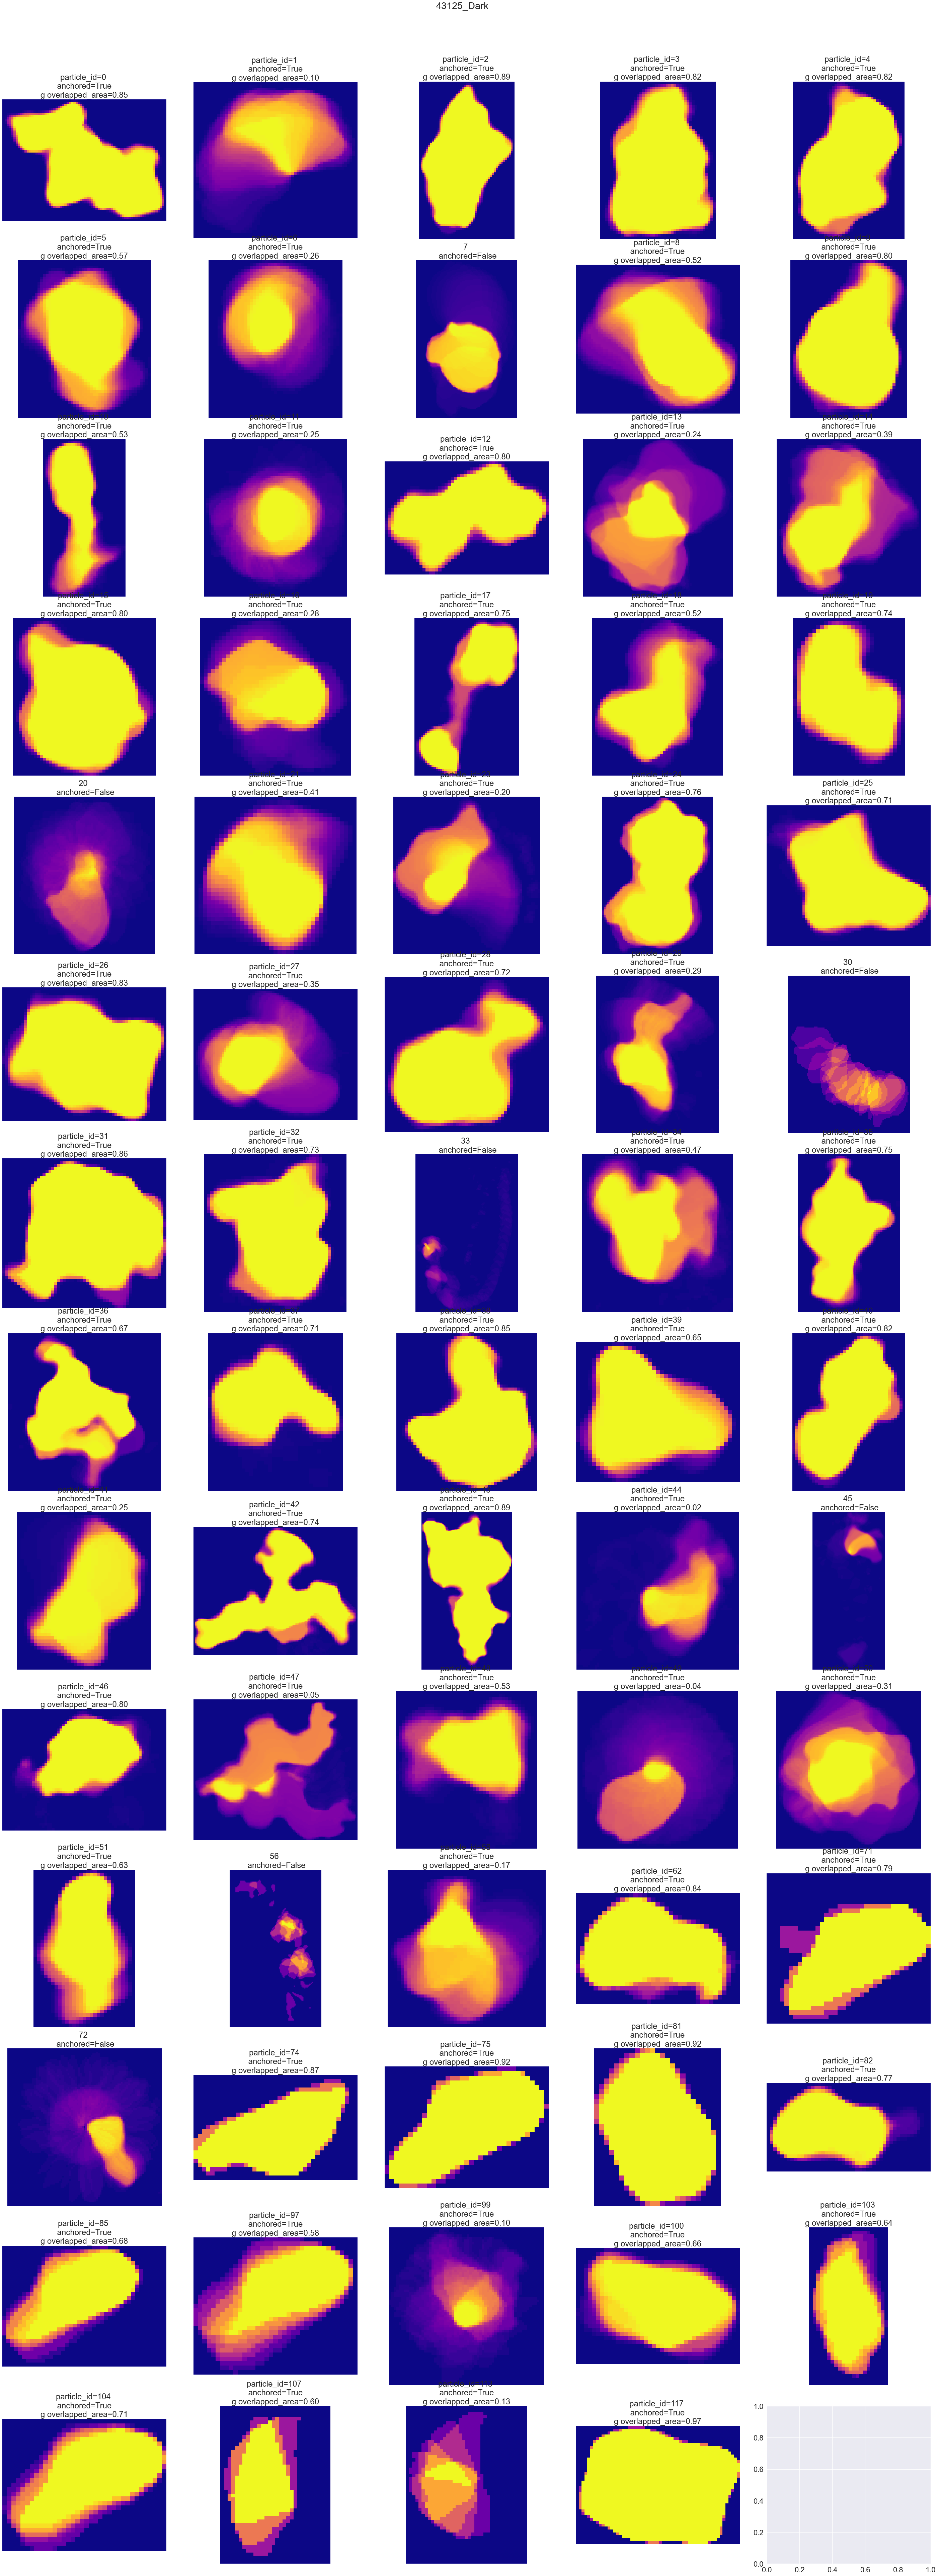

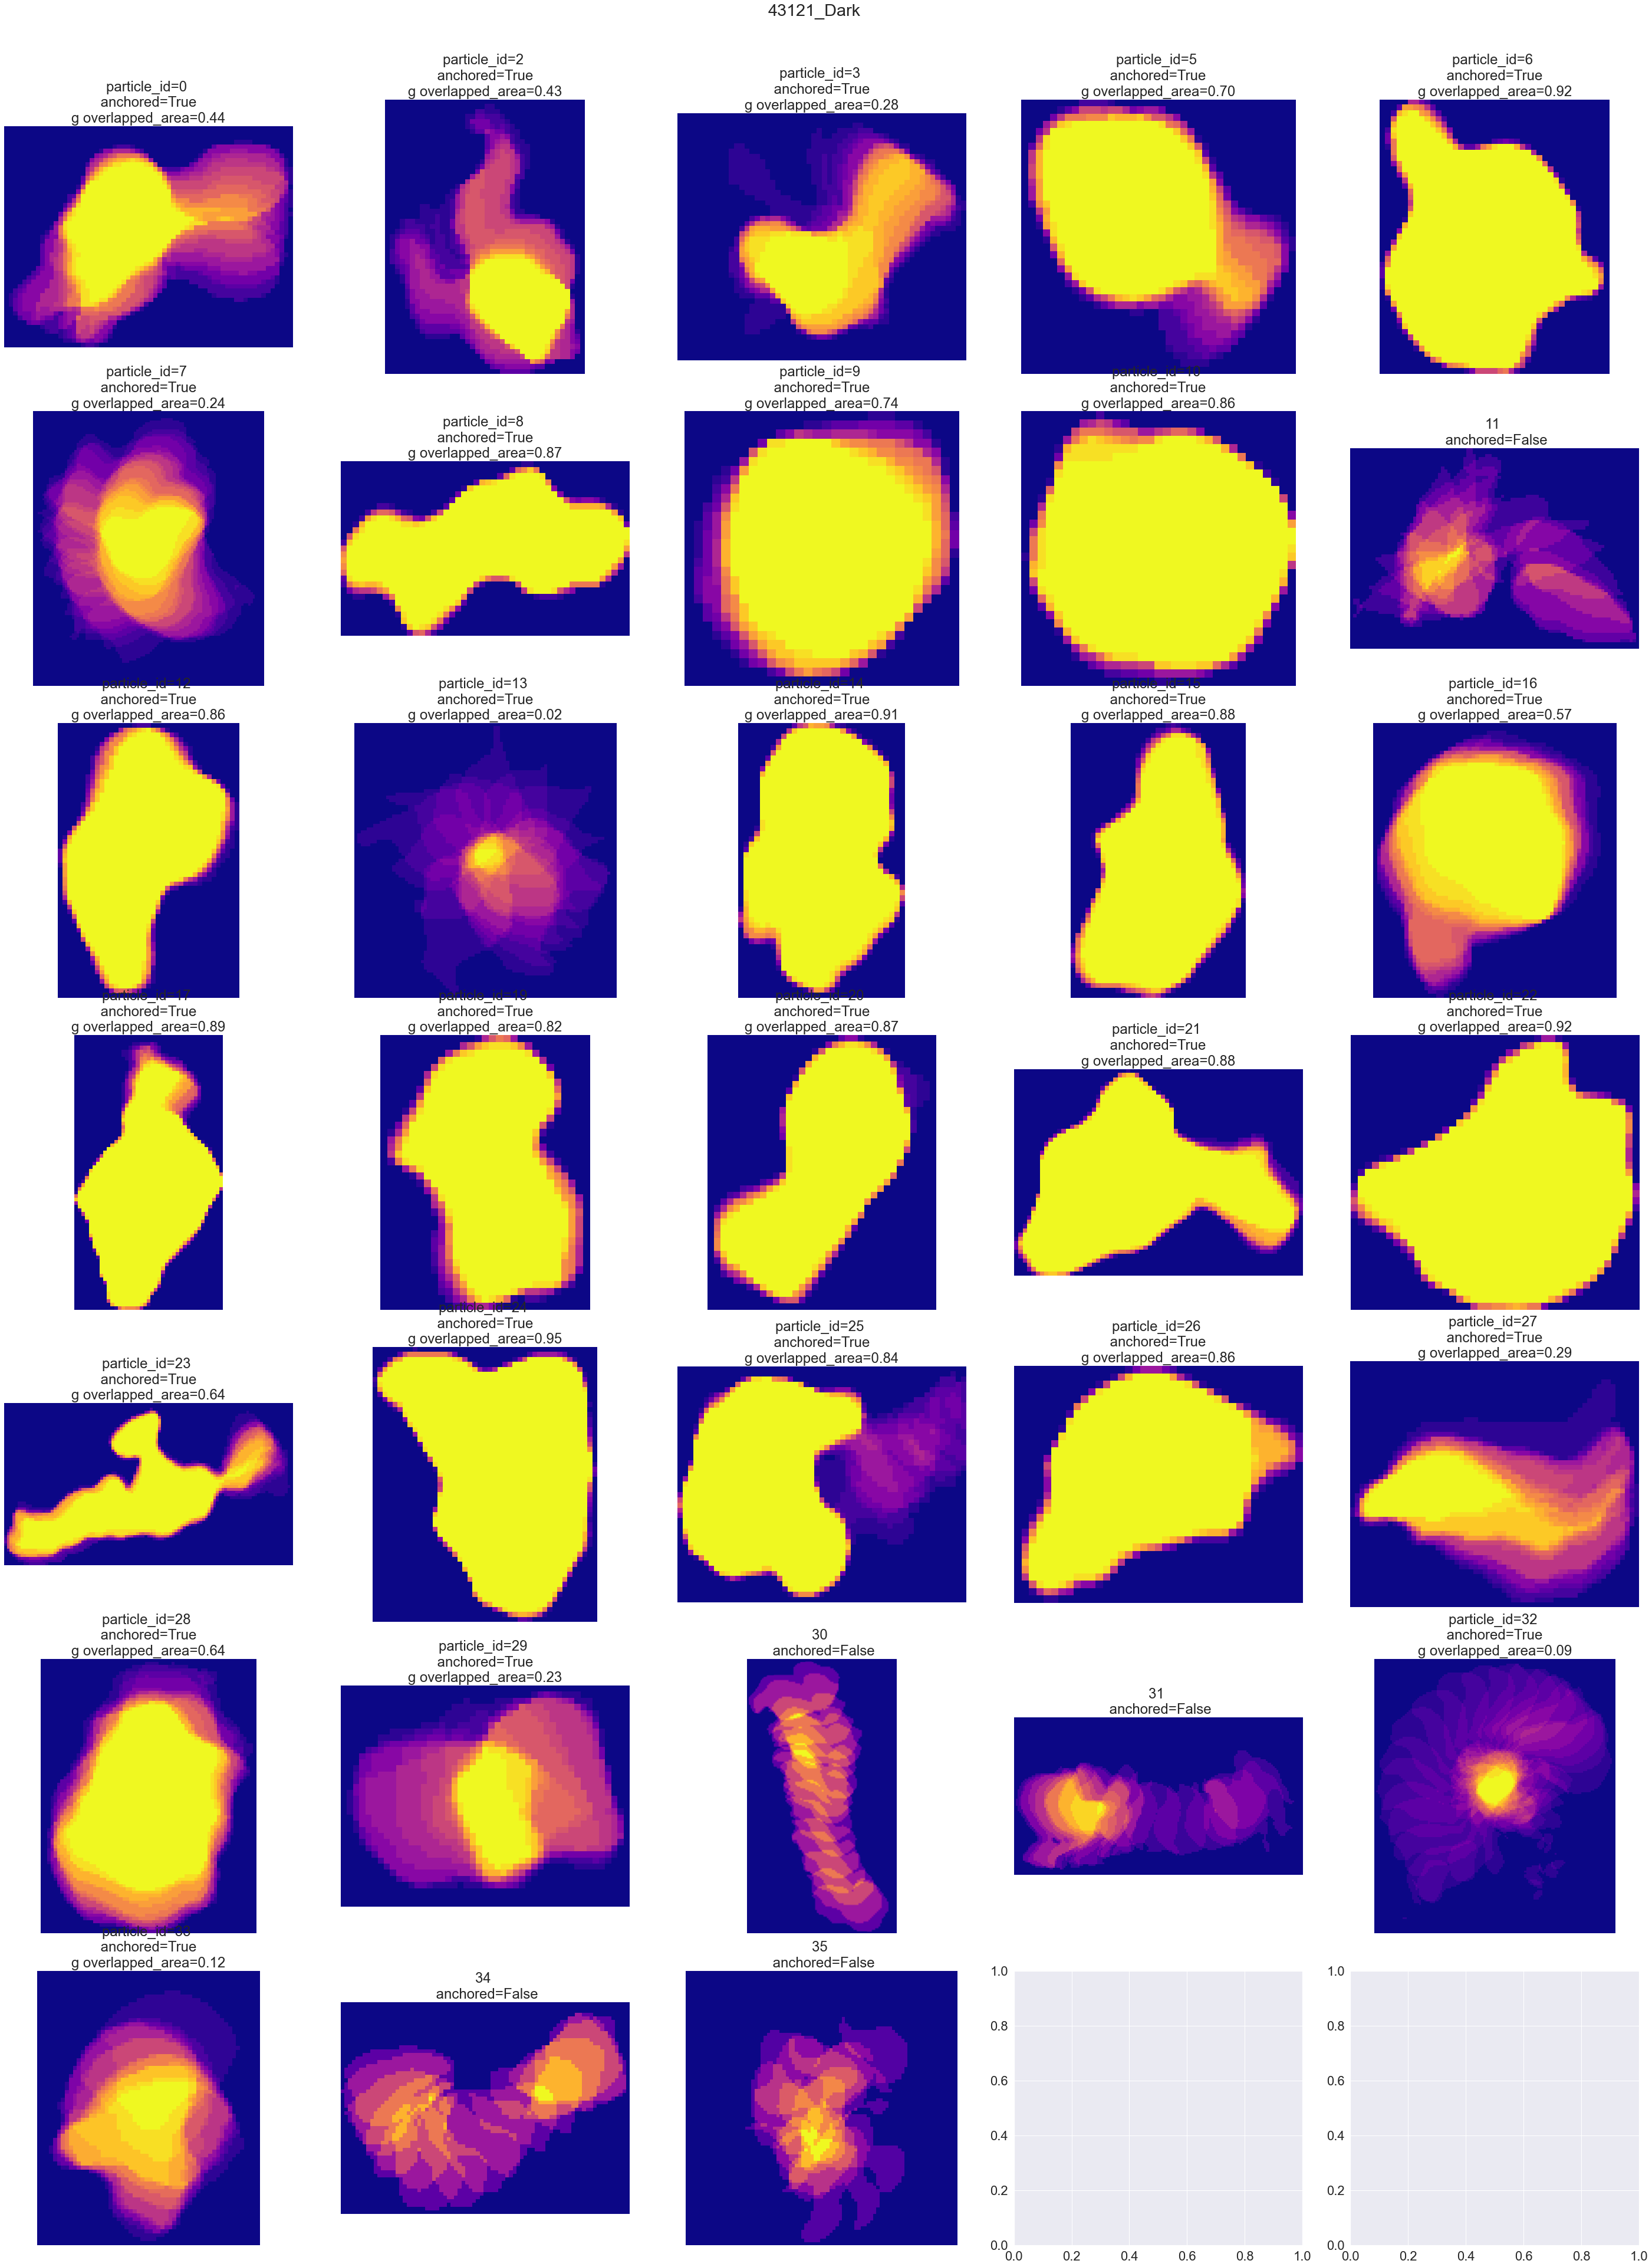

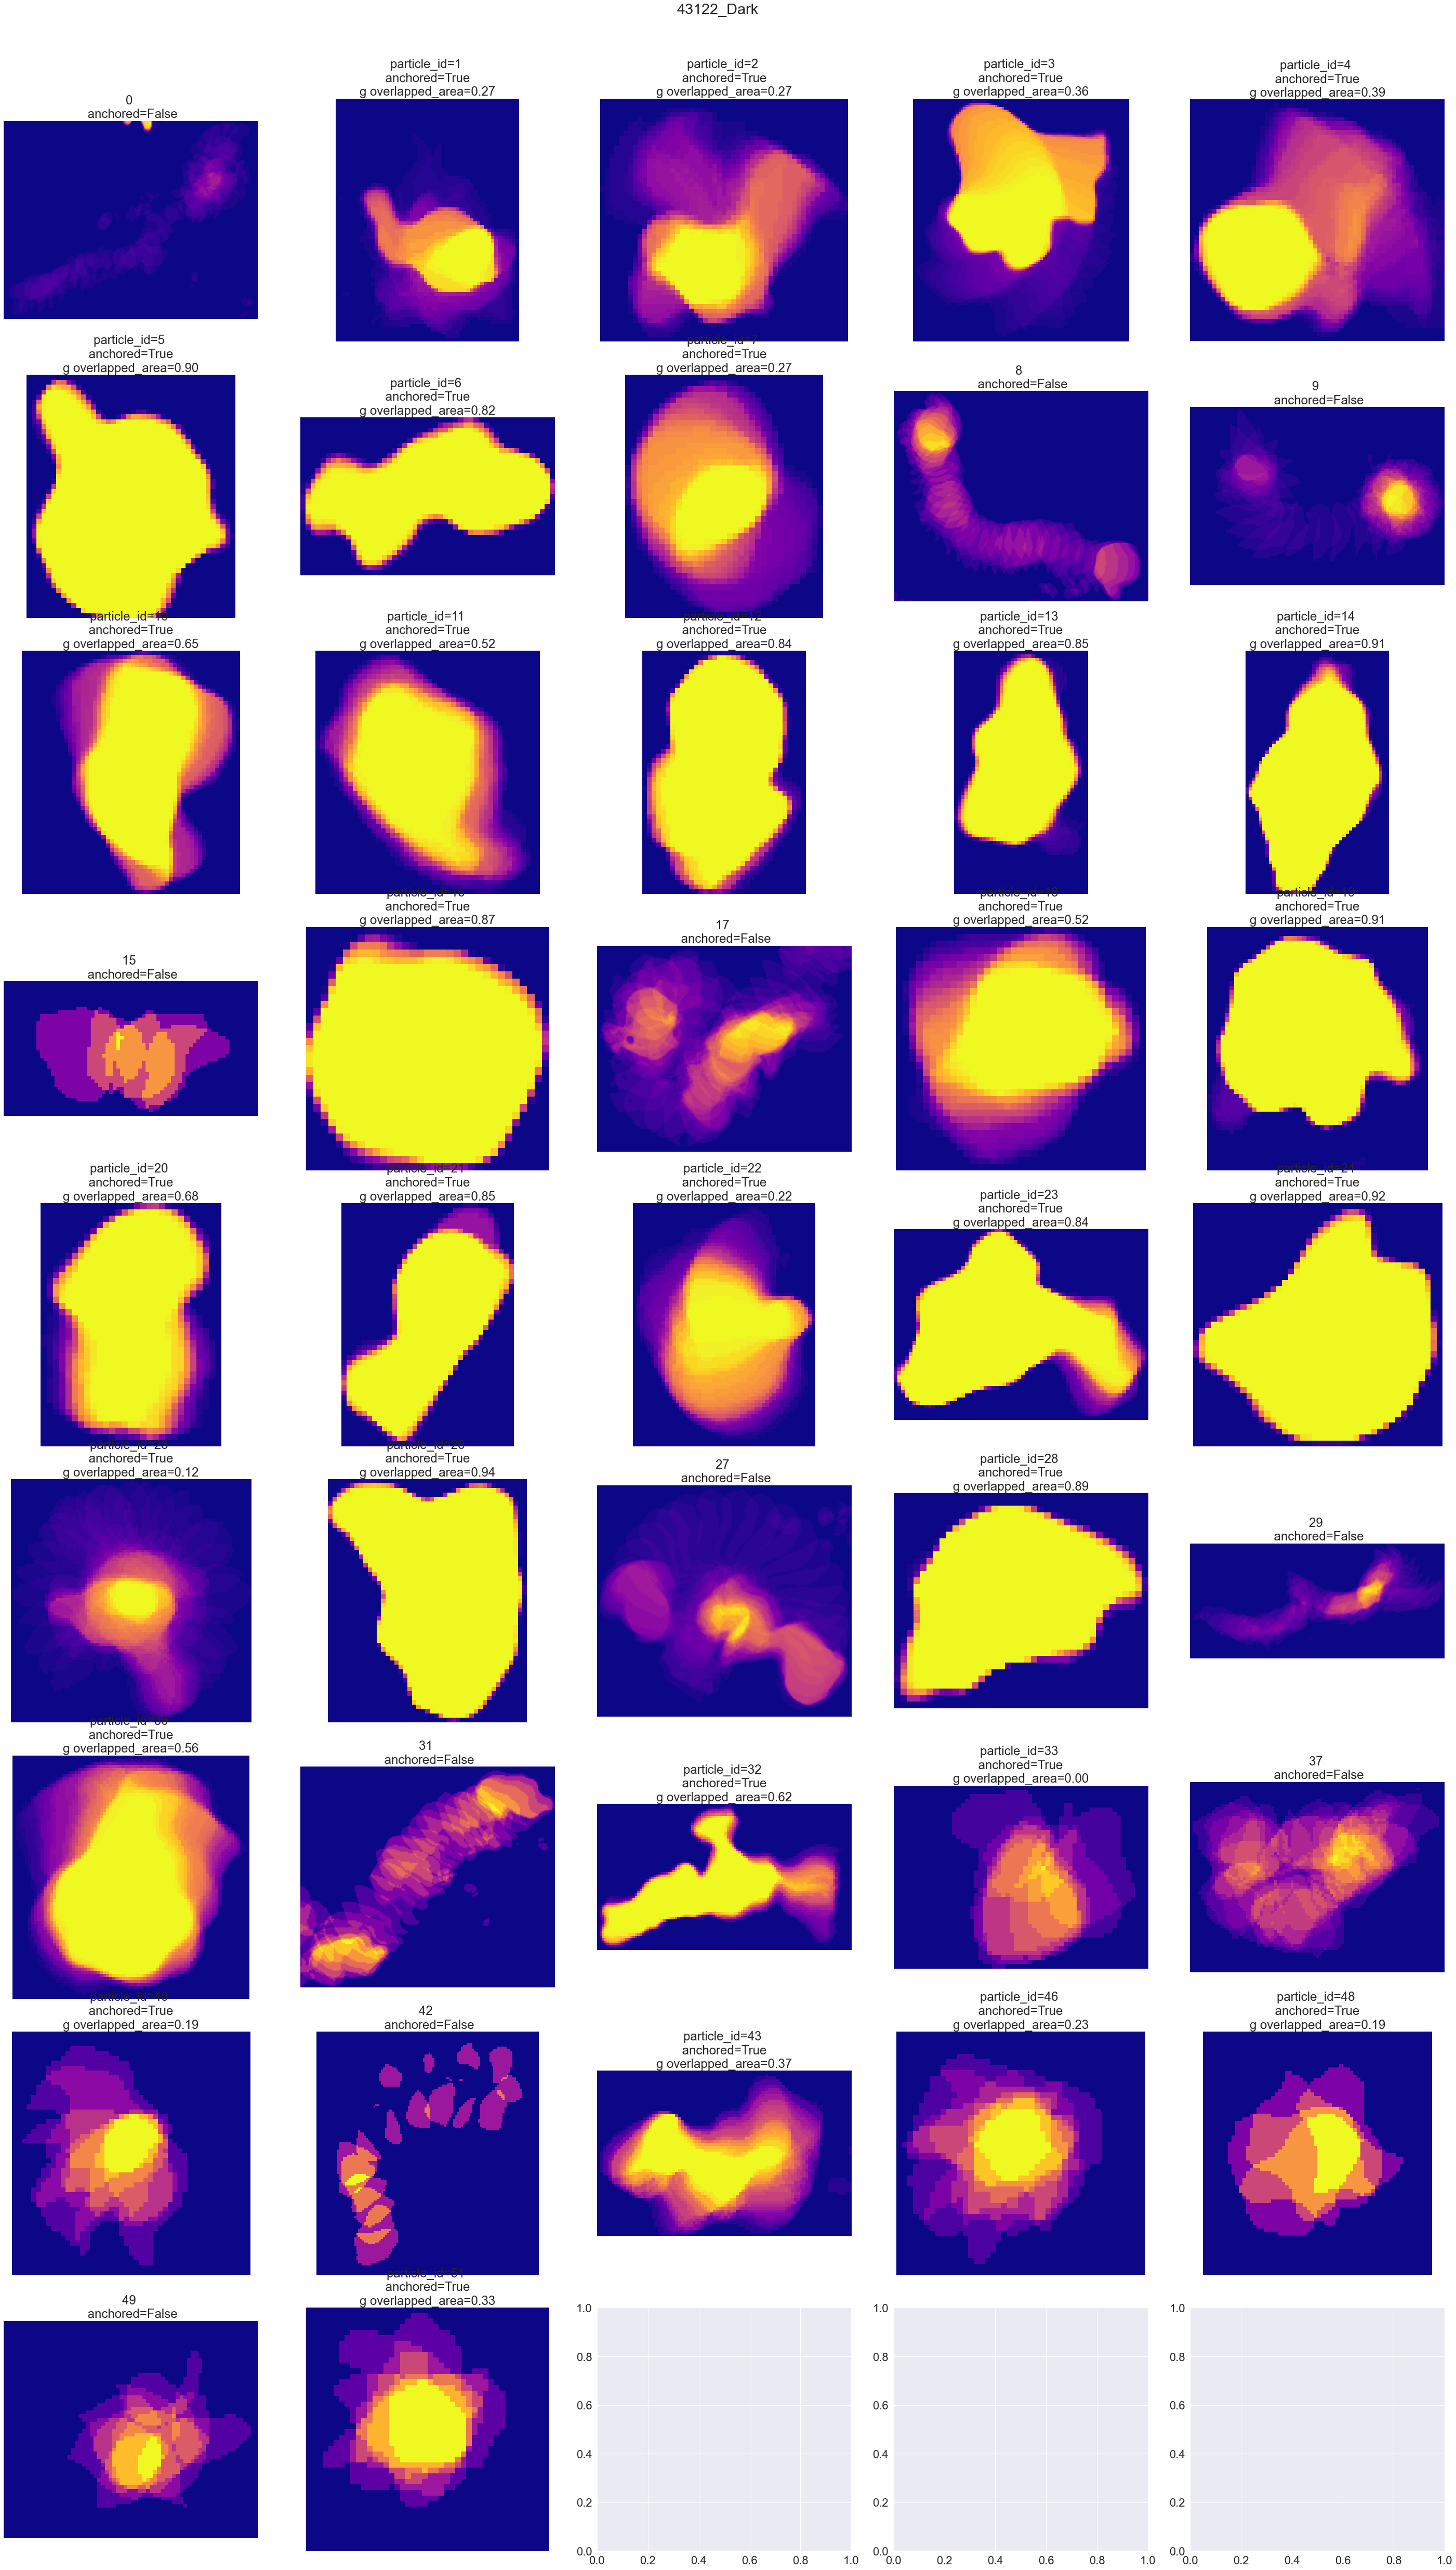

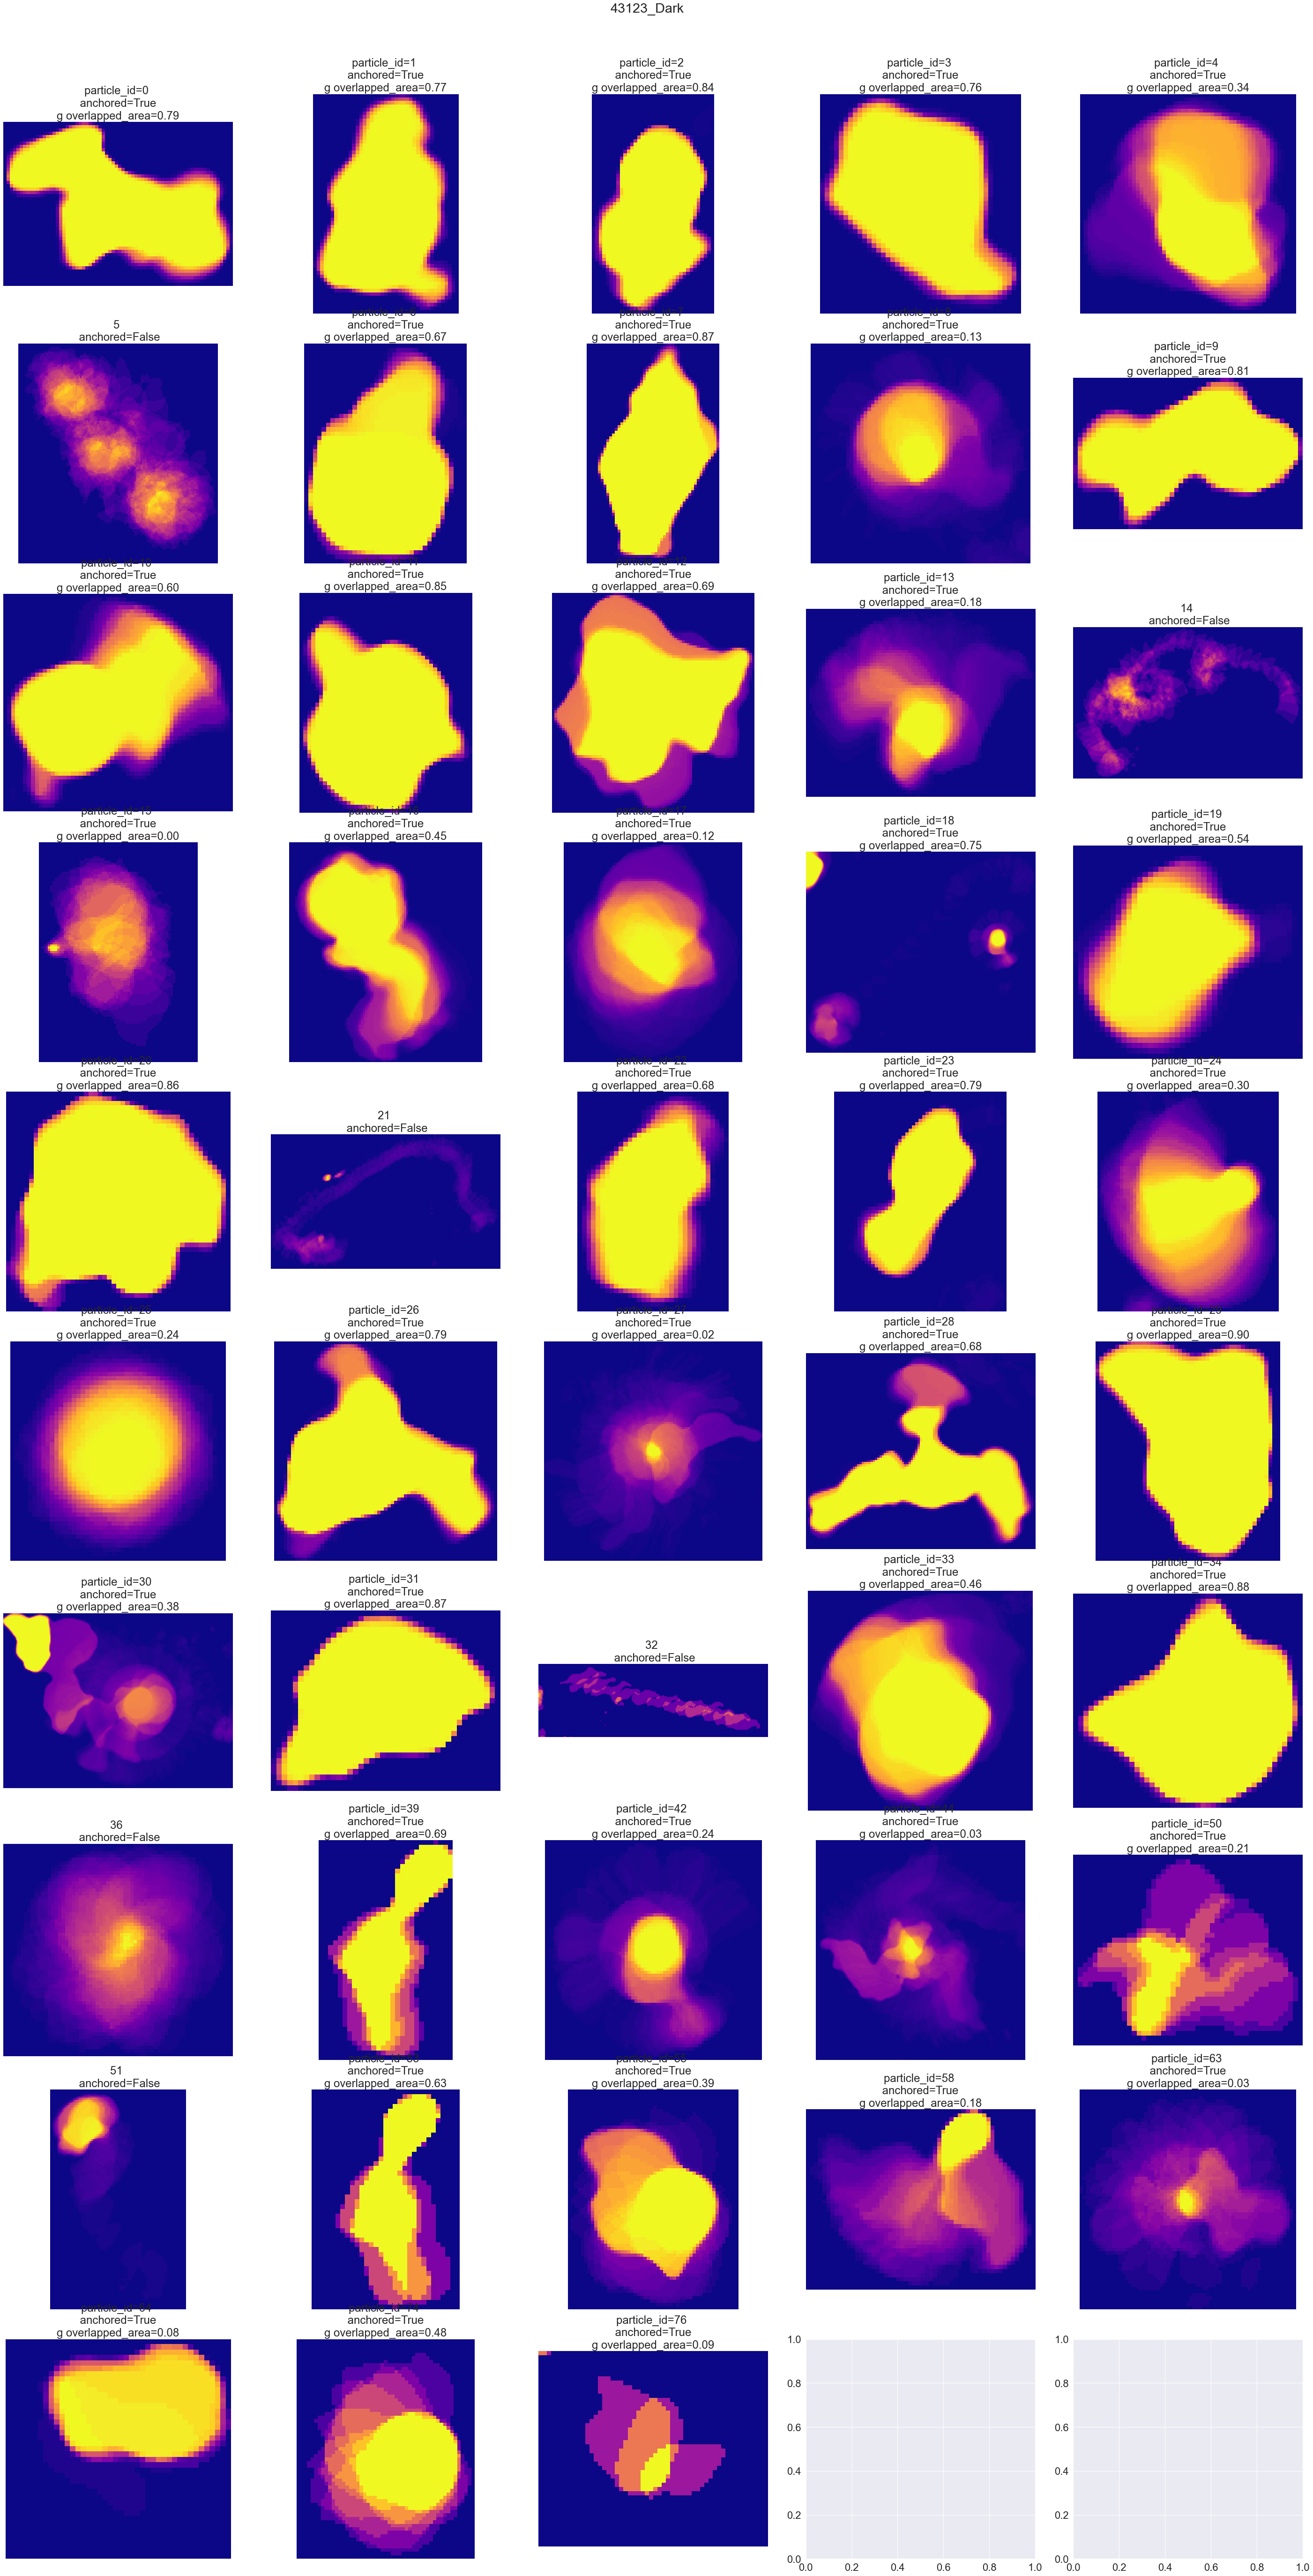

In [12]:
Tracks_len=5
sns.set(font_scale=2)
Anchor_all=pd.DataFrame()

for file_prefix in images_dict.keys():
    print(file_prefix)
    
    tracks=images_dict[file_prefix]["tracks_big"]
    binary_images=images_dict[file_prefix]["binary"]

    # traj longer then 5 frames
    tracks_length=tracks.groupby('particle').apply(len)
    particle_select=tracks_length[tracks_length>Tracks_len].index.values
    tracks_filters=tracks[tracks['particle'].isin(particle_select)]
    
    Ngroups=tracks.groupby('particle').ngroups
    Nrows=np.int(np.ceil(Ngroups/5))
    fig,ax=plt.subplots(nrows=Nrows,ncols=5,figsize=(40,Nrows*7.5))
    suptitle = plt.suptitle(file_prefix, y=1.02)
    plt.tight_layout()
    axx=ax.ravel()


    counter=0
    Anchor_data=[]
    for id, traj in tracks.groupby('particle'):
        result=object_anchor_area(traj,binary_images,axx[counter])
        counter=counter+1
        Anchor_data.append(result)

    Anchor_df=pd.DataFrame(Anchor_data)
    Anchor_df["type"]="fixed"
    Anchor_df["type"][Anchor_df["overlapped_area_ratio"]<=0.50]="rotating"
    Anchor_df["type"][Anchor_df["overlapped_area_ratio"]==0]="moving"
    Anchor_df['file_prefix']=file_prefix
    Anchor_df.to_csv("../results/Anchor_area_{}.csv".format(file_prefix))
    #plt.savefig("../results/Projection_plot_{}.png".format(file_prefix), bbox_extra_artists=(suptitle,), bbox_inches="tight")
    
    
    Anchor_all=pd.concat([Anchor_df,Anchor_all])



## Class of the object does not depend on the 

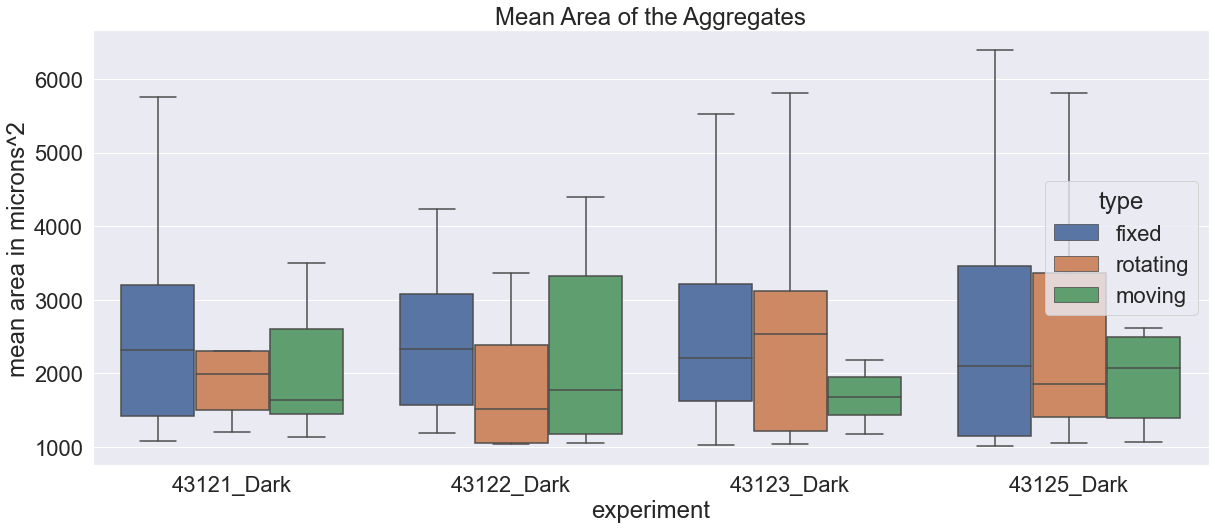

In [36]:

dxx=1.42 # micron/px

fig,ax=plt.subplots(figsize=(20,8))
Anchor_all["mean_area_micron2"]=Anchor_all["mean_area"]*dxx*dxx
my_order=['43121_Dark', '43122_Dark', '43123_Dark','43125_Dark']
sns.boxplot(x='file_prefix',y="mean_area_micron2",hue='type',data=Anchor_all,order=my_order,showfliers = False,ax=ax)
ax.set_title("Mean Area of the Aggregates")
ax.set_ylabel("mean area in microns^2")
ax.set_xlabel("experiment")
plt.savefig("../results/MeanArea_Aggregate_{}.png",bbox_inches="tight")

### Plot patriclular class of the objects

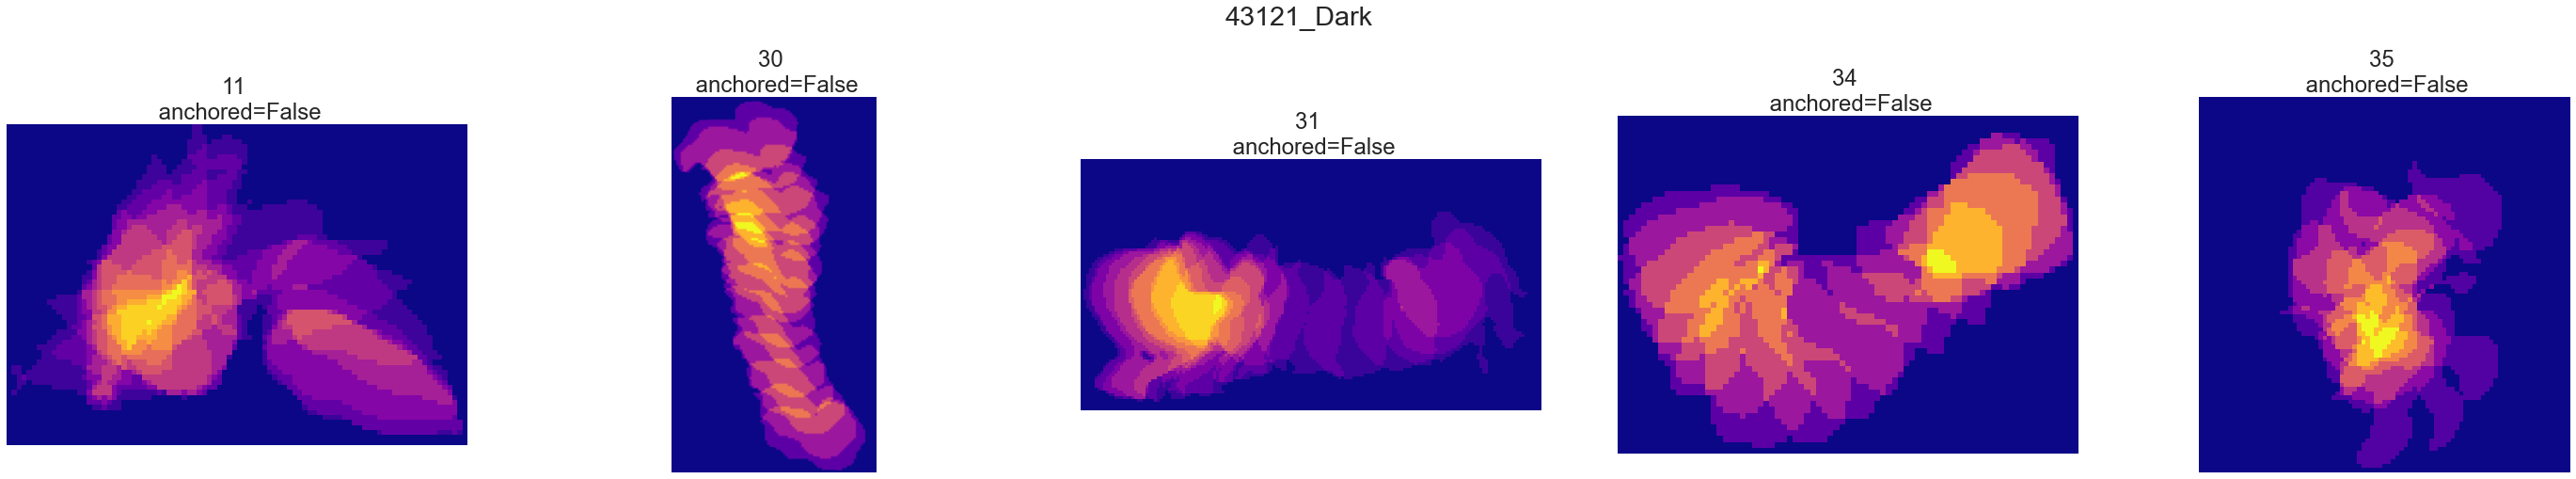

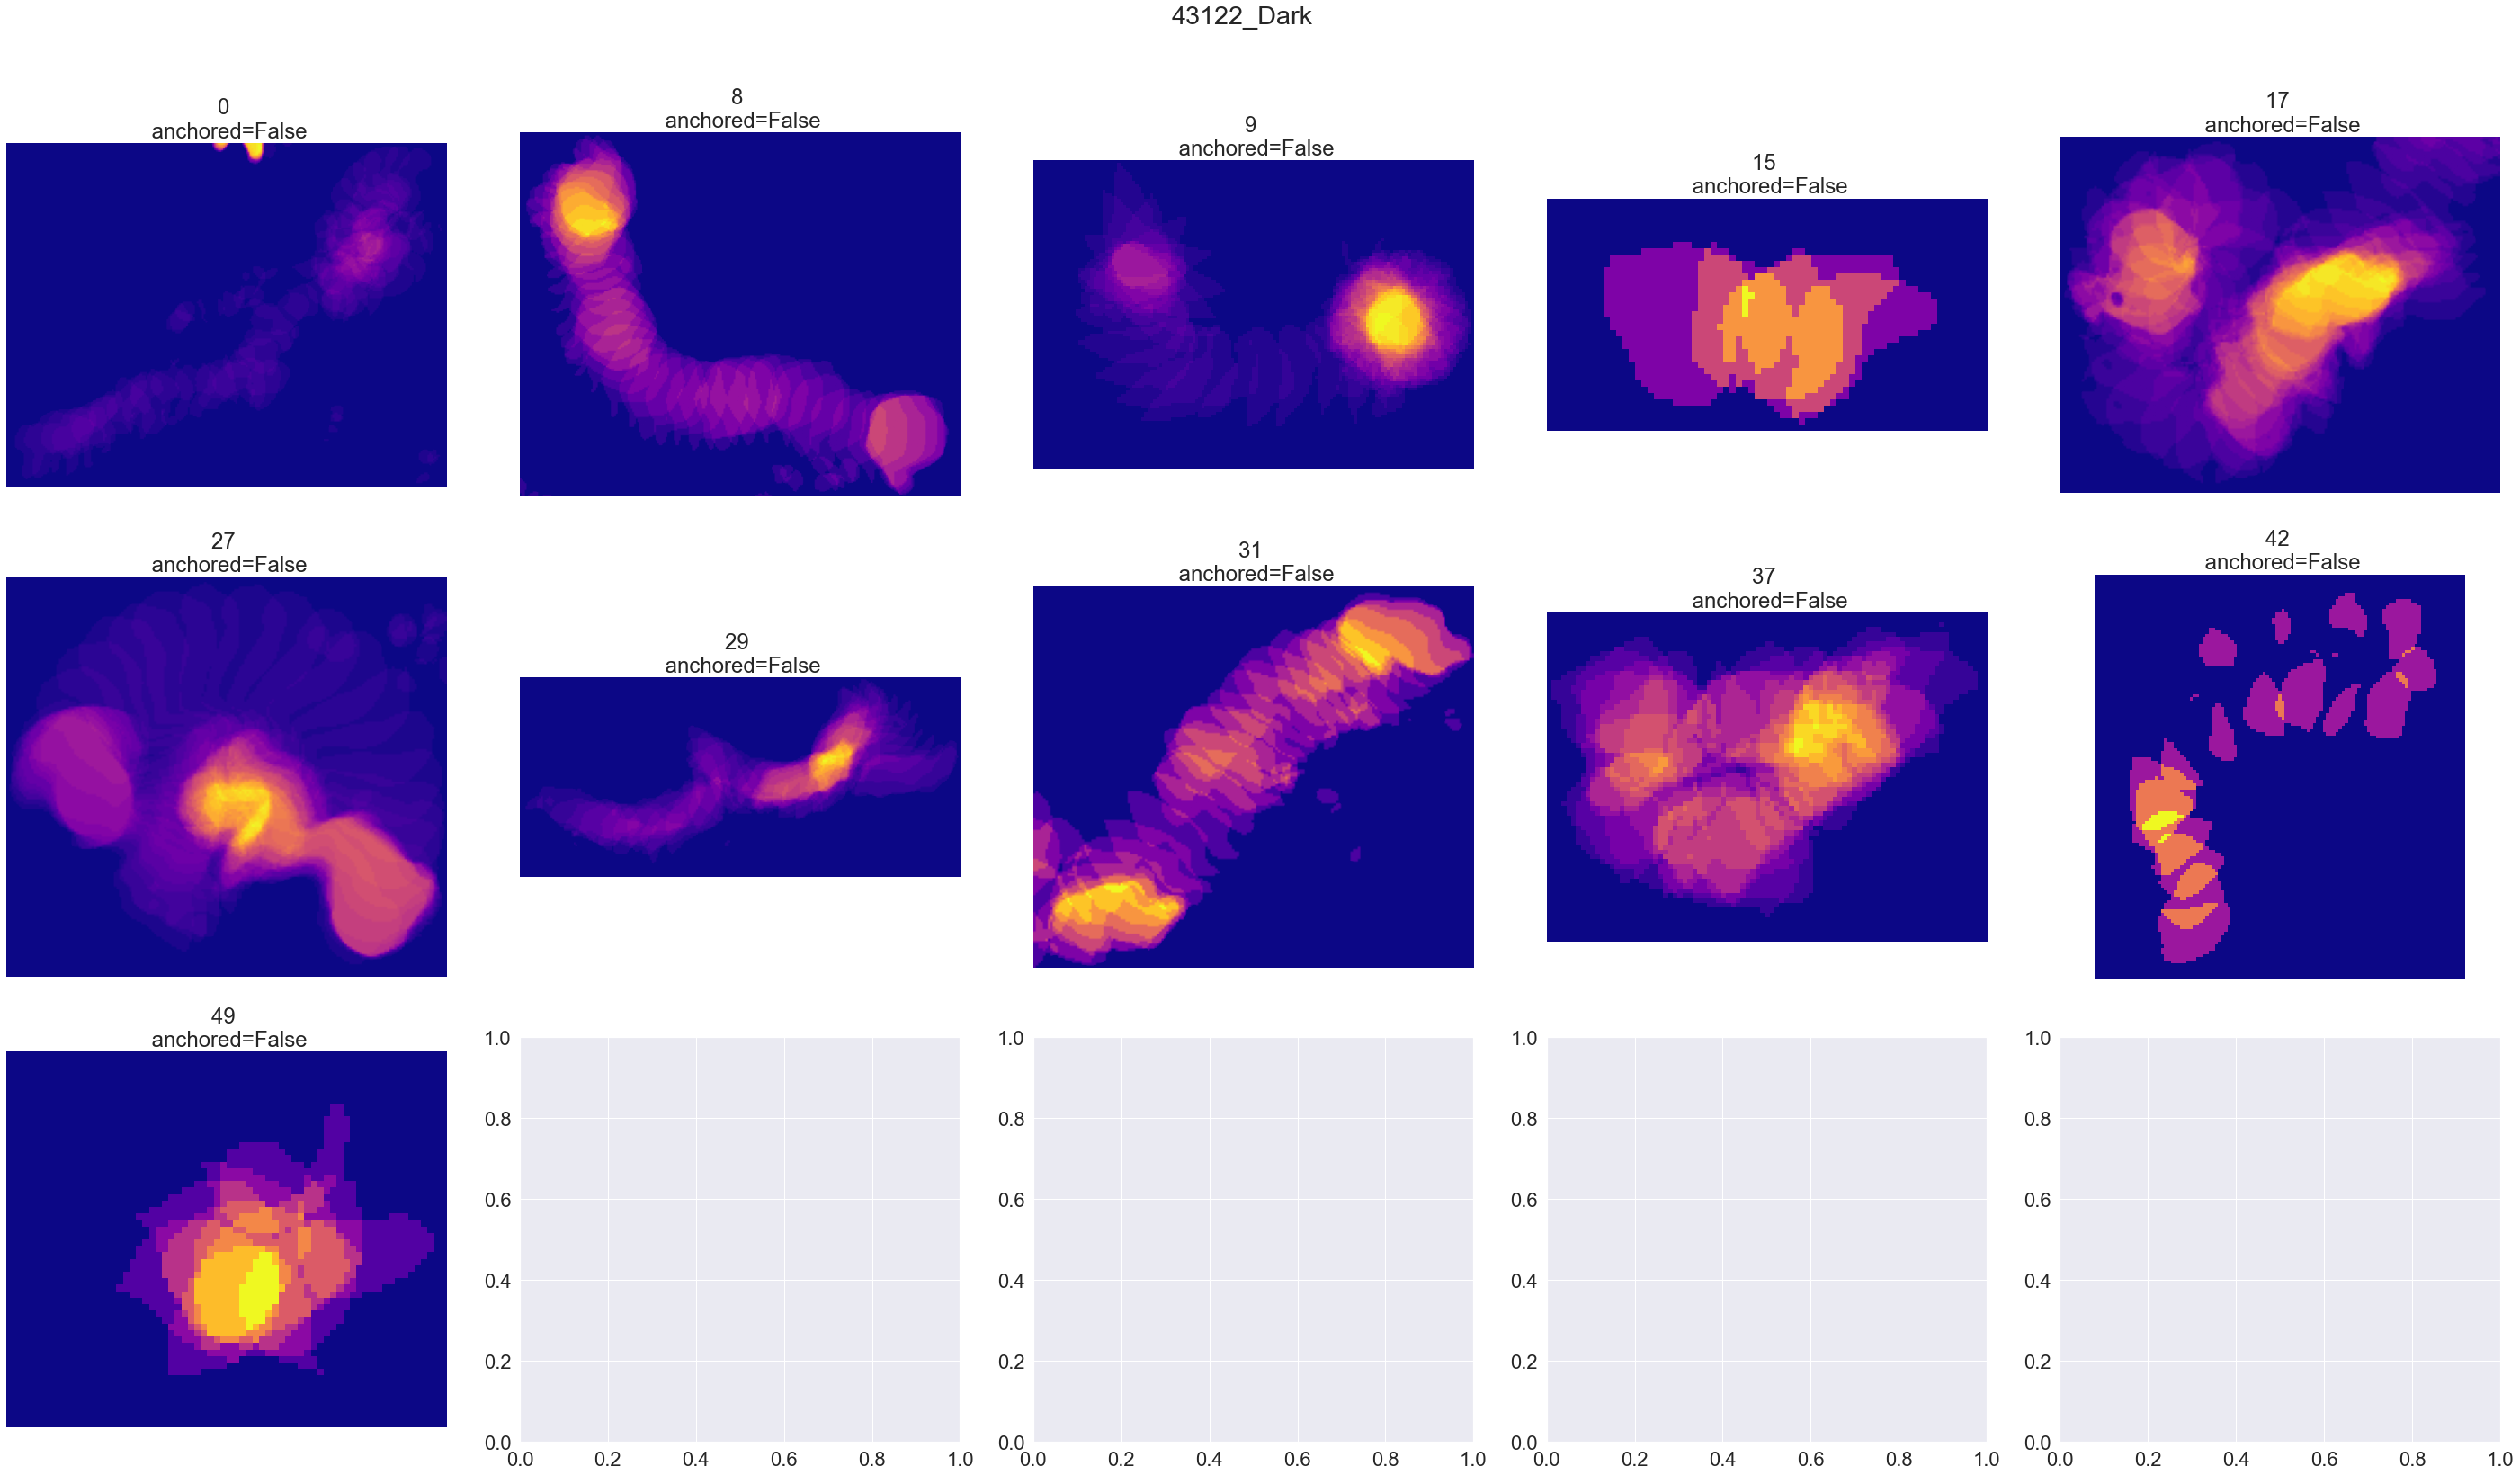

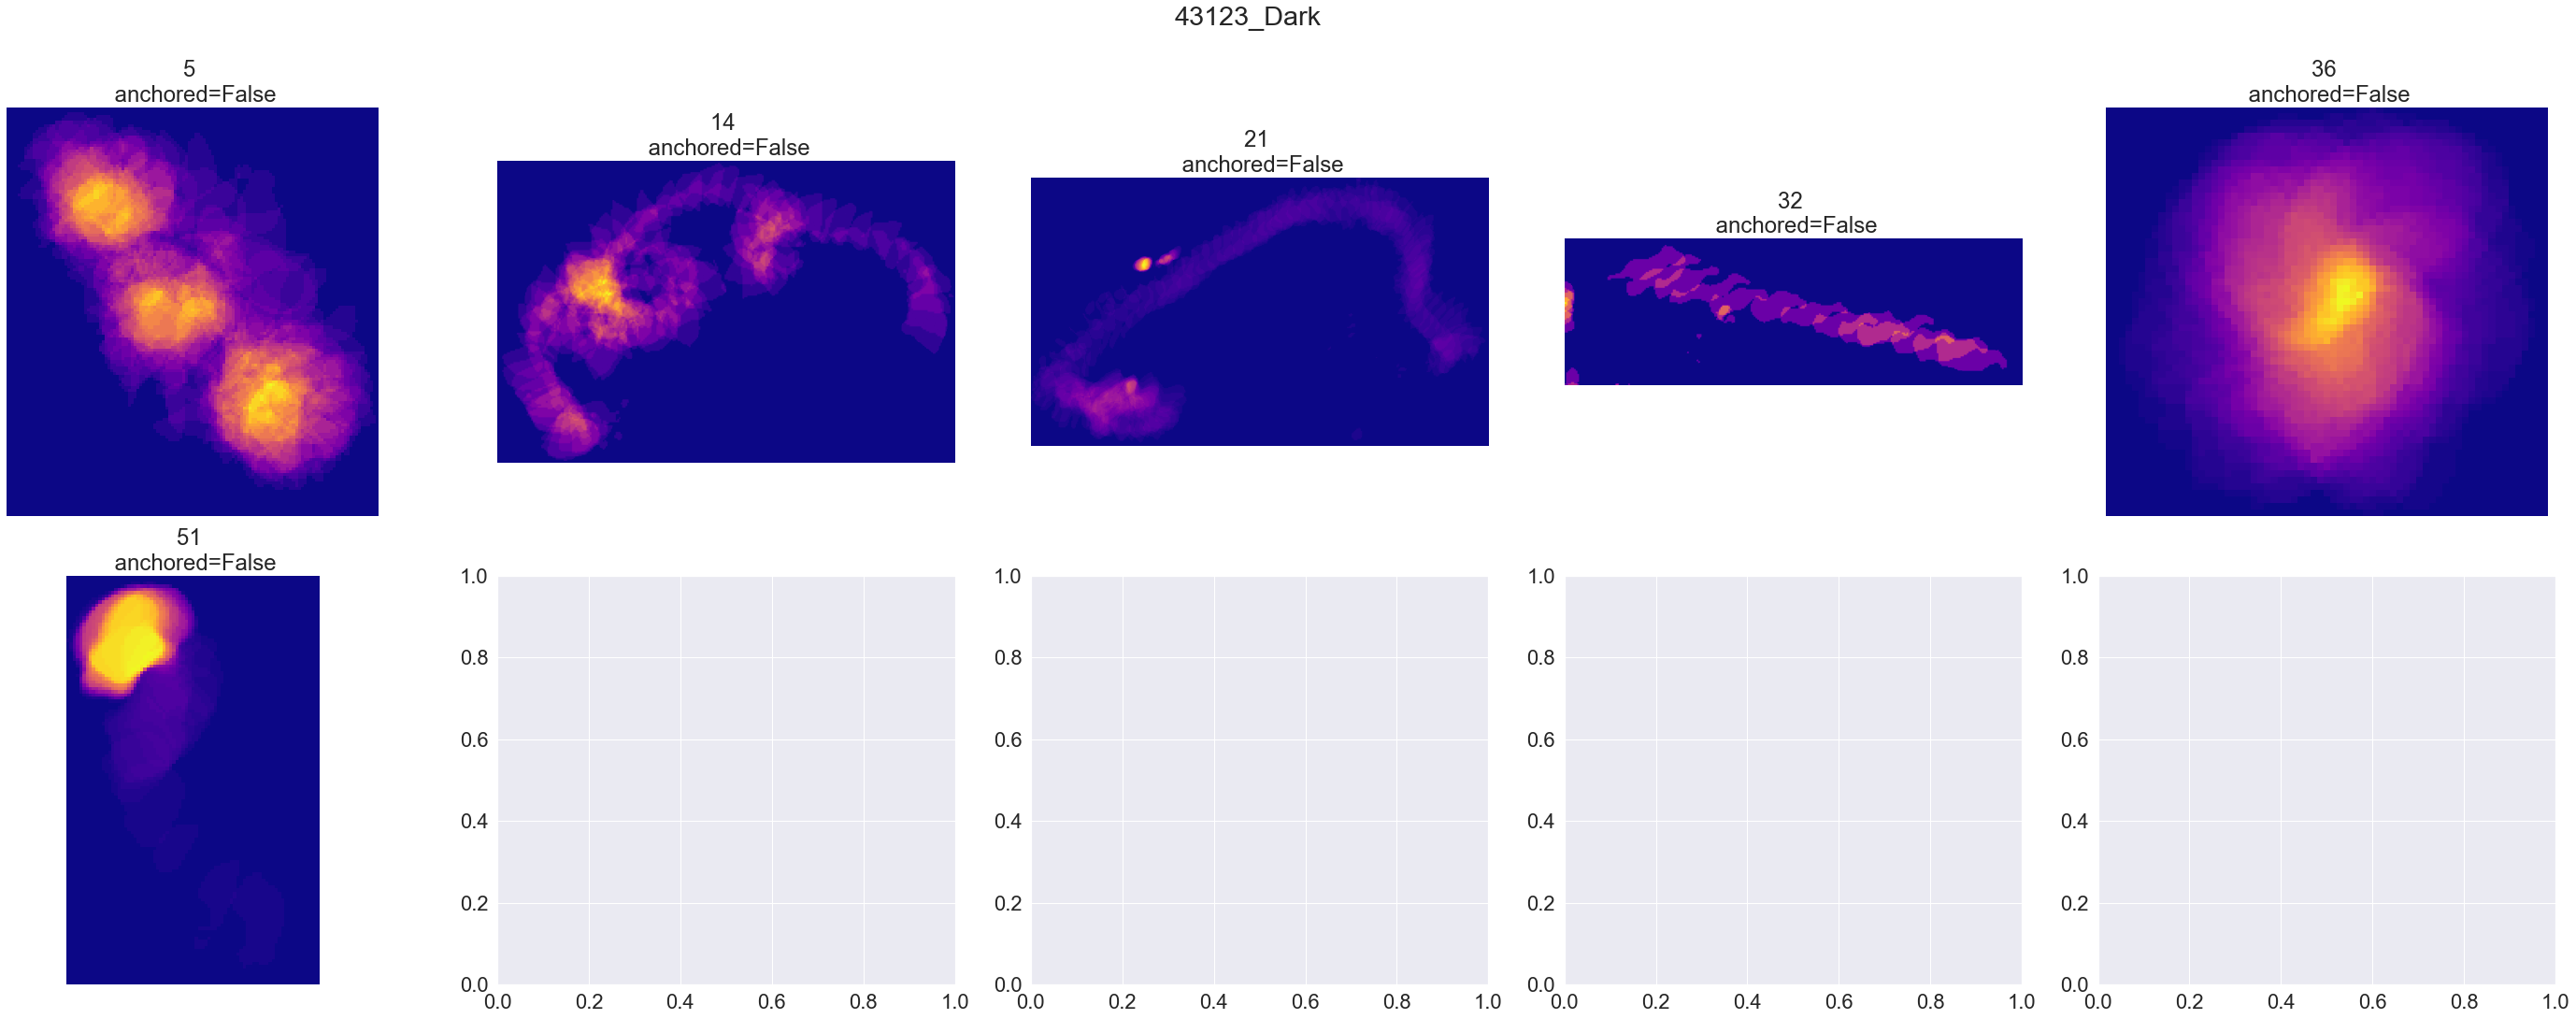

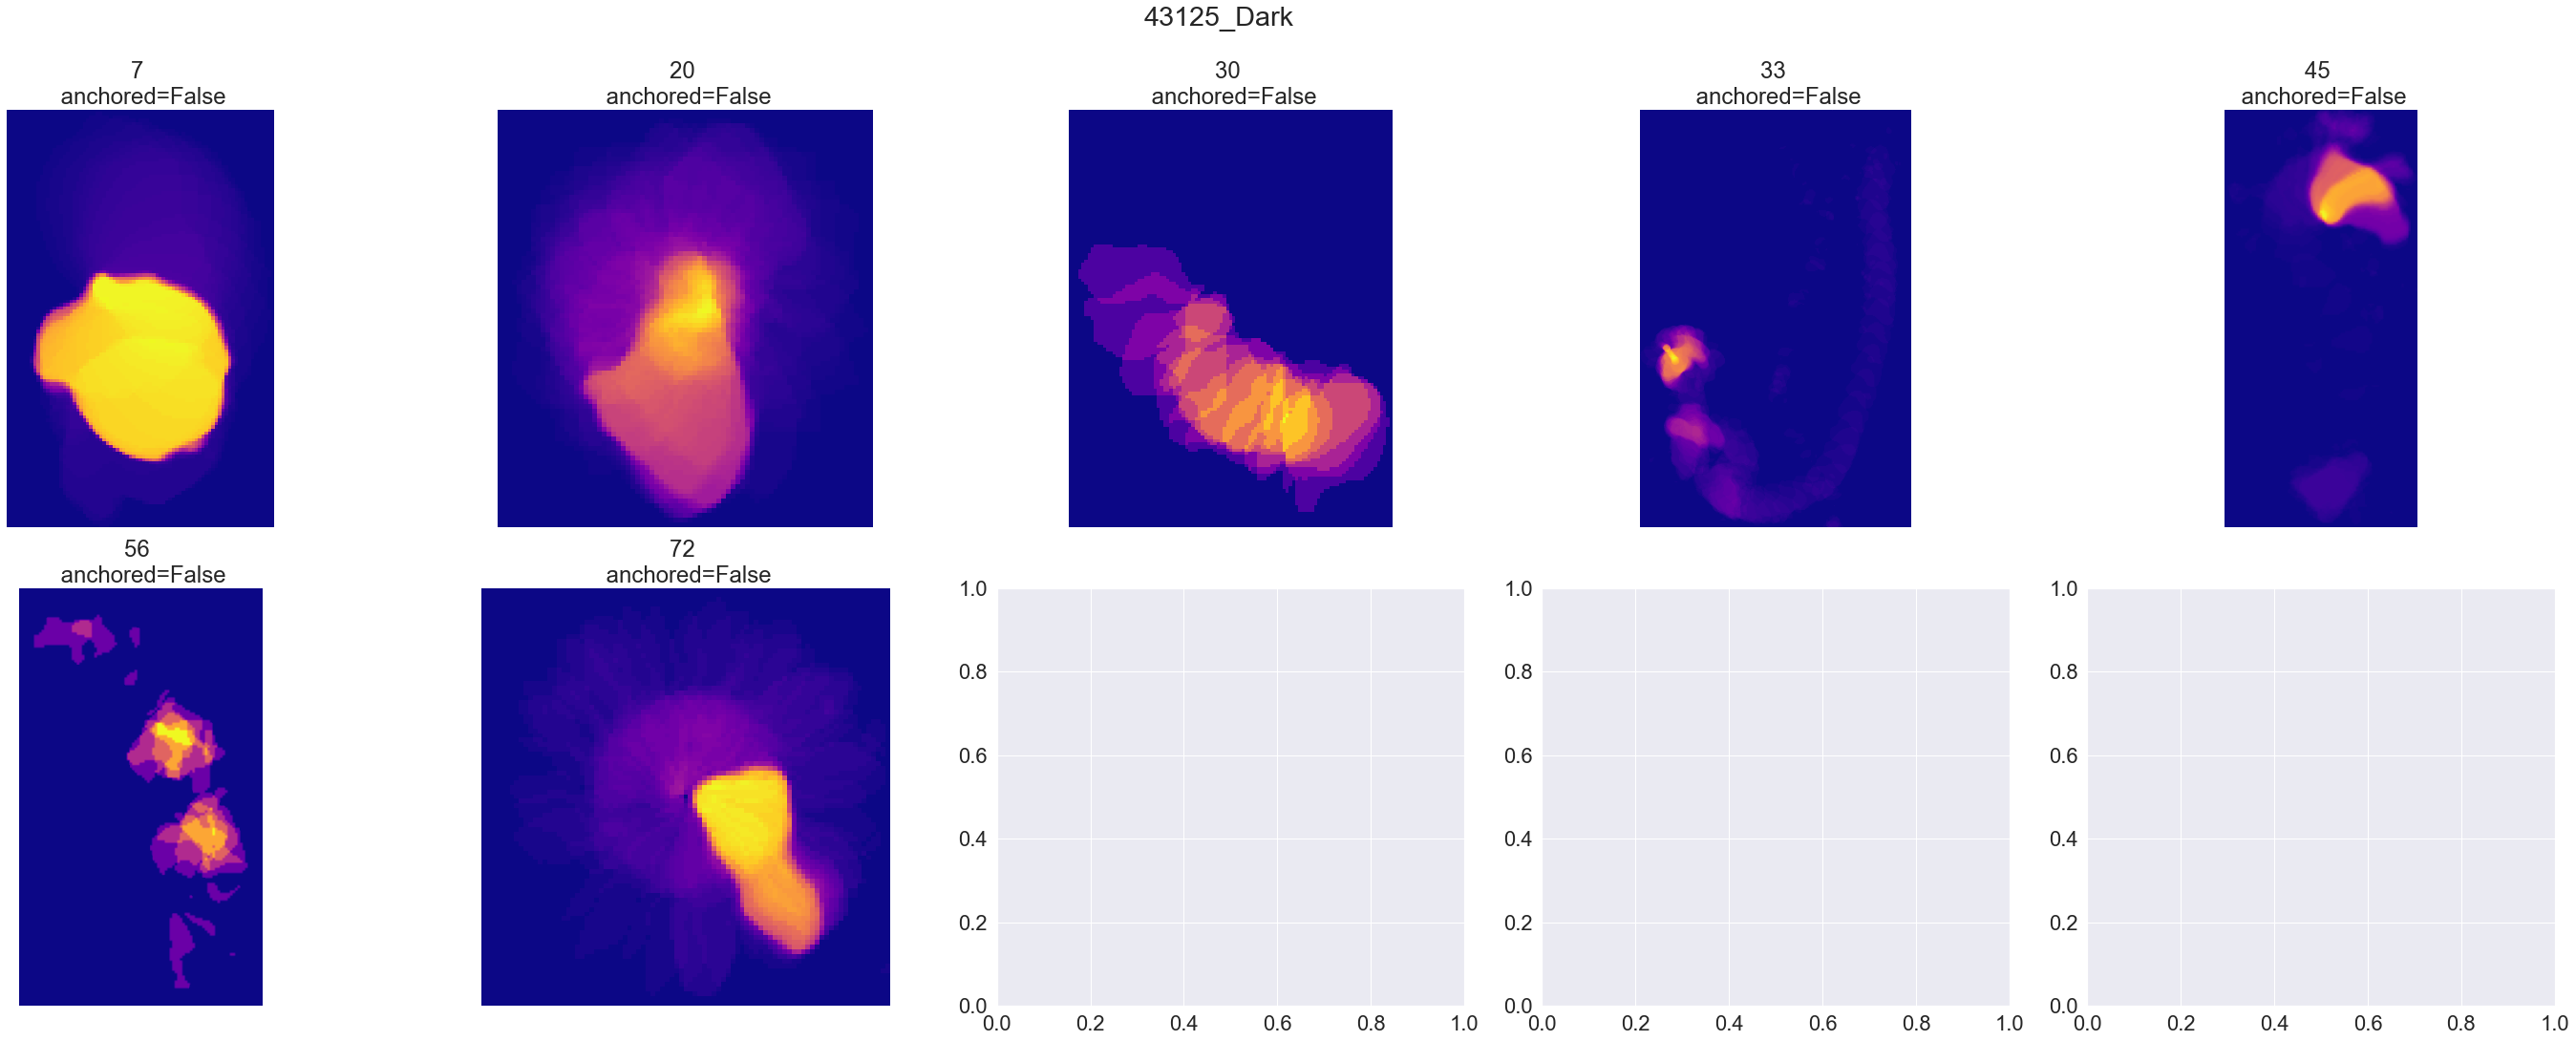

In [81]:
Moving_particles=Anchor_all[Anchor_all["type"]=='moving']


Moving_particles=Moving_particles.reset_index()
for file_prefix in my_order:
    selection=Moving_particles[Moving_particles["file_prefix"]==file_prefix]
    tracks=images_dict[file_prefix]["tracks_big"]
    binary_images=images_dict[file_prefix]["binary"]
    
    Nparticles=selection.shape[0]
    Nrows=np.int(np.ceil(Nparticles/5))

    
    fig,ax=plt.subplots(nrows=Nrows,ncols=5,figsize=(40,Nrows*7.5))
    suptitle = plt.suptitle(file_prefix, y=1.02)
    plt.tight_layout()
    
    axx=ax.ravel()
    counter=0
    for k in selection.index:
        particle=selection.loc[k]['particle']
        traj=tracks[(tracks["file_name"]==file_prefix) & (tracks["particle"]==particle)]
        result=object_anchor_area(traj,binary_images,axx[counter])
        counter=counter+1

    plt.savefig("../results/Moving_particles_overlay_{}.png".format(file_prefix),bbox_inches="tight")            

In [78]:
tracks[(tracks["file_name"]==file_prefix) & (tracks["particle"]==particle)]

frame  Unnamed: 0  index  label            y            x  \
9        0         124    124    125  1447.698507  2637.570149   
32       1         304    130    131  1448.539514  2638.141337   
64       2         483    130    131  1447.606432  2637.727412   
95       3         669    134    135  1444.180030  2636.751891   
128      4         853    136    137  1436.439169  2637.314540   
160      5        1029    130    131  1433.748191  2636.487699   
190      6        1206    124    125  1429.911278  2627.348872   
224      7        1388    137    138  1424.060914  2616.868020   
257      8        1567    132    133  1427.468354  2607.815752   
289      9        1745    133    134  1427.504762  2597.572789   
322     10        1932    137    138  1425.472262  2597.728307   
355     11        2111    128    129  1422.987688  2597.503420   
388     12        2283    126    127  1423.031250  2596.906250   
421     13        2458    125    126  1429.298772  2596.619372   
455     14        2637    126    127  1433.891746  2597.380244   
488     15        2824    141    142  1436.422572  2595.653543   
520     16        2996    127    128  1439.142857  2594.166667   
553     17        3175    131    132  1441.069737  2595.580263   
582     18        3358    135    136  1442.437419  2594.829677   
620     19        3531    127    128  1443.083445  2593.368775   

     major_axis_length  minor_axis_length  orientation  area  ...  \
9            44.003175          19.622468     1.163872   670  ...   
32           42.793624          19.772169     1.083070   658  ...   
64           42.790849          19.631727     1.134981   653  ...   
95           43.154311          19.772284     1.095776   661  ...   
128          44.320408          19.801536     0.848037   674  ...   
160          44.882077          19.814419     1.217332   691  ...   
190          44.865437          19.105635    -1.377613   665  ...   
224          51.218115          22.308433    -1.232191   788  ...   
257          48.246781          19.501770    -0.997746   711  ...   
289          52.269516          18.931247    -0.675165   735  ...   
322          52.716605          17.737922    -0.600109   703  ...   
355          54.313966          18.694574    -0.533041   731  ...   
388          50.393967          18.696645    -0.249153   704  ...   
421          49.179304          19.837308     0.124155   733  ...   
455          48.166567          20.675286     0.639852   739  ...   
488          47.493154          22.963412     1.264990   762  ...   
520          46.561048          22.598789     1.558548   756  ...   
553          47.847639          22.131698    -1.251605   760  ...   
582          48.432850          22.320783    -1.147310   775  ...   
620          46.695231          22.237376    -0.917124   743  ...   

     max_intensity  mean_intensity  min_intensity  compactness  circularity  \
9         0.080664        0.052770       0.030342    17.974467     0.699123   
32        0.080786        0.052659       0.030310    16.992359     0.739531   
64        0.083023        0.053610       0.030397    16.855226     0.745547   
95        0.084501        0.053975       0.030364    17.103173     0.734739   
128       0.080988        0.052219       0.030344    18.026169     0.697118   
160       0.081372        0.053269       0.030320    17.537372     0.716548   
190       0.083593        0.053932       0.030304    17.678625     0.710823   
224       0.082013        0.053671       0.030303    21.748566     0.577802   
257       0.080656        0.054439       0.030401    19.350859     0.649396   
289       0.080852        0.052300       0.030338    22.299651     0.563523   
322       0.079584        0.051714       0.030338    24.794365     0.506824   
355       0.077682        0.051586       0.030356    25.529876     0.492222   
388       0.076549        0.051730       0.030315    20.849959     0.602705   
421       0.080598        0.053534       0.030363    19.402067

In [69]:
tracks["file_name"].unique()

array(['43123_Dark'], dtype=object)

## Speed
Speed analysis of not anchored particles

In [ ]:
def plot_trajectory_particle_XY_view(particle,ax):
    traj=tracks[tracks["particle"]==particle]
    traj=traj.sort_values(by=["frame"])
    
    ax.plot(traj['x'],traj['y'],'-o',label="particle={}".format(particle))
    ax.set_title("Trajectory")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    
    
    # plot anomalies
    anomalies=simple_anomaly_detector(traj,ax,5,1.5,plot_flag=False)
    traj_anomalies=traj[traj.frame.isin(anomalies.index)]
    
    #print("anomalies R","particle={} frames={}".format(particle,anomalies.index),traj_anomalies.x)
    ax.plot(traj_anomalies['x'],traj_anomalies['y'],"ro", markersize=5,label="anomalies")
    ax.legend()
    
def plot_trajectory_particle_R(particle,ax):
    traj=tracks[tracks["particle"]==particle]
    traj=traj.sort_values(by=["frame"])
    start_x=traj['x'].values[0]
    start_y=traj['y'].values[0]
    traj['r']=np.sqrt((traj['x'].values-start_x)**2+(traj['y'].values-start_y)**2)

    ax.plot(traj['frame'],traj['r'],'-o',label="particle={}".format(particle))
    ax.set_title("Radius vector")
    ax.set_xlabel("frame")
    ax.set_ylabel("Radius vector")
    
    # plot anomalies
    anomalies=simple_anomaly_detector(traj,ax,5,1.5,plot_flag=False)
    traj_anomalies=traj[traj.frame.isin(anomalies.index)]
    
    ax.plot(traj_anomalies.frame,traj_anomalies.r,"ro", markersize=5,label="anomalies")
    ax.legend()
    
def plot_trajectory_particle_V(particle,ax):
    traj=tracks[tracks["particle"]==particle]
    traj=traj.sort_values(by=["frame"])
    start_x=traj['x'].values[0]
    start_y=traj['y'].values[0]
    r=np.sqrt((traj['x'].values-start_x)**2+(traj['y'].values-start_y)**2)
    traj['r']=r
    traj["speed"]=np.nan
    traj["speed"][1:]=np.diff(r)
    
#   ax.plot(traj['frame'],traj["speed"],'-o',label="particle={}".format(particle))
    ax.set_title("Speed")
    ax.set_xlabel("frame")
    ax.set_ylabel("Speed")
    
    anomalies=simple_anomaly_detector(traj,ax,5,1.5,plot_flag=True)
    traj_anomalies=traj[traj.frame.isin(anomalies.index)]
    ax.plot(traj_anomalies.frame,traj_anomalies.speed,'ro')
    ax.legend()
    

def simple_anomaly_detector(traj,ax,window=3,scale=1.95,plot_flag=False):
    """
    simple anomaly detector
    """
    break_id=[]
    start_x=traj['x'].values[0]
    start_y=traj['y'].values[0]
    r=np.sqrt((traj['x'].values-start_x)**2+(traj['y'].values-start_y)**2)
    traj['r']=r
    traj["speed"]=np.nan
    traj["speed"][1:]=np.diff(r)
    
    # set minimal size of trajectories for anomaly detection
    anomalies=pd.Series('NA',index=[])
    if (traj.shape[0]>5):
        tt=traj.copy()
        tt=tt.sort_values('frame')
        tt=tt.set_index('frame')
        tt=tt['speed']
    
        
        # find candidates for anomaly
        rolling_mean = tt.rolling(window=5).mean()
        mae=mean_absolute_error(tt[window:], rolling_mean[window:])
        deviation = np.std(tt[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        
        
        anomalies_lower = tt[tt<lower_bond]
        anomalies_upper = tt[tt>upper_bond]
        anomalies=pd.concat([anomalies_upper,anomalies_lower])
        
       
        if (plot_flag==True):
            # plot anomalies
            #fig,ax=plt.subplots(figsize=(8,5))
            ax.set_title("trajectory id = {}".format(traj["particle"].values[0]))
            ax.plot(rolling_mean, "g",lw=3,label="Rolling mean trend") # label="Rolling mean trend"
            ax.plot(tt, color="darkblue", label="data")
            ax.plot(upper_bond, "r--",label="Upper Bond / Lower Bond") #label="Upper Bond / Lower Bond"
            ax.plot(lower_bond, "r--")
#             ax.plot(anomalies_upper, "ro", markersize=5,label="anomalies")
#             ax.plot(anomalies_lower, "ro", markersize=5)
            ax.legend()
    return anomalies

    

In [ ]:
moving_particle=Anchor_df[Anchor_df["anchored"]==0]["particle"].values
sns.set(font_scale=1)

fig,ax=plt.subplots(nrows=moving_particle.shape[0],ncols=3,figsize=(15,moving_particle.shape[0]*5))
suptitle = plt.suptitle(file_prefix, y=0.9)

counter=0
for particle_id in moving_particle:
    plot_trajectory_particle_XY_view(particle_id,ax[counter,0])
    plot_trajectory_particle_R(particle_id,ax[counter,1])
    plot_trajectory_particle_V(particle_id,ax[counter,2])
    #seed_analysis(particle_id,ax)
    counter=counter+1
    
plt.savefig("../results/Moving_trajectories_{}.png".format(file_prefix), bbox_extra_artists=(suptitle,), bbox_inches="tight")

## Orientation

In [ ]:
def orientation(traj,ax):
    particle=traj['particle'].values[0]
    time=traj['frame'].values
    
    # elivate big jumps of angle 
    # due to the transition from [pi/2,delta+pi/2] or [-pi/2,-delta-pi/2]
    delta=2
    d_orientation=np.diff(traj.orientation)
    d_orientation=np.where((d_orientation)>delta,d_orientation-np.pi,d_orientation)
    d_orientation=np.where((d_orientation)<-delta,d_orientation+np.pi,d_orientation)
    angle=np.cumsum(d_orientation)
    angle=angle*180/np.pi
    
    #========================#
    # median eccentricity
    eccentricity=np.median(traj['eccentricity'])
    
    # max diff angle
    max_diff_angle=np.max(np.abs(d_orientation))*180/np.pi
    
    # cumsum
    cumsum_angle=angle[-1]
    #========================#
    
    result={"particle":particle,
            "med_eccentricity":eccentricity,
            "max_diff_angle":max_diff_angle,
            "cumsum_angle":cumsum_angle}
    
    #angle=angle.rolling(3).median().values
    s = pd.Series(angle)
    #pd.plotting.autocorrelation_plot(s,ax=ax)
    #ax.legend(str(particle))
    ax.plot(traj.frame[1:],angle,'-o',lw=3,label='particle={:}\ne={:.2f}'.format(particle,np.median(eccentricity)))
    ax.legend()
    
    
    return result


##==============================================================##
sns.set(font_scale=2)
Nrows=np.int(np.ceil(Ngroups/5))
fig,ax=plt.subplots(nrows=Nrows,ncols=5,figsize=(40,Nrows*7.5))
suptitle = plt.suptitle(file_prefix, y=1.02)
plt.tight_layout()
axx=ax.ravel()

counter=0
Orientation=list()
for id, traj in tracks.groupby('particle'):
    result=orientation(traj,axx[counter])
    Orientation.append(result)
    counter=counter+1
    
Orientation=pd.DataFrame(Orientation)

plt.savefig("../results/Angle_{}.png".format(file_prefix), bbox_extra_artists=(suptitle,), bbox_inches="tight")

In [ ]:
Orientation[["med_eccentricity",'max_diff_angle','cumsum_angle']].hist(layout=(1,3),figsize=(15,5));

In [ ]:
import ipyvolume as ipv
ipv.figure()
#ipv.volshow(X3d.astype(float))
# add scatter plot
x=X3d[:,0]
y=X3d[:,1]
z=X3d[:,2]

ipv.scatter(x = X3d[:,0], y = X3d[:,1], z = X3d[:,2], size=1.5, color = "red")
# ipv.scatter(x = X3d[(cluster==1),0].astype(float), y = X3d[(cluster==1),1].astype(float), z = X3d[(cluster==1),2].astype(float), size=1.5, color = "blue")
ipv.show()
